In [ ]:
import pyomo.environ as pyo
import pyomo.gdp as gdp
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal

In [ ]:
training_points = multivariate_normal.rvs(size=(10,2))

# df = pd.DataFrame(training_points)
# df.to_csv('training_points_causing_problem.csv')

# df = pd.read_csv("training_points_causing_problem.csv") 
# training_points = df.values[:,1:]

In [ ]:
training_points

In [ ]:

class RarePatternDetect:
    def __init__(self, training_set: np.array, min_area: float):
        self.training_set = training_set # a N x d matrix
        self.min_area = min_area # the smallest allowed area
        self.N, self.d = self.training_set.shape
        self.Nrange, self.drange = (range(x) for x in self.training_set.shape)
        self.largest_bounding_area = np.array([
            [
                np.min(self.training_set[:,0]),
                np.min(self.training_set[:,1])
            ], 
            [
                np.max(self.training_set[:,0]),
                np.max(self.training_set[:,1])
            ]])
        self.model = self.create_model()
           
    
    def create_model(self):
        def _pattern_area():
            return pyo.prod(model.interval_lengths[i] for i in self.drange)

        # define model
        model = pyo.ConcreteModel()

        ## variables

        # x is a 2d vector
        model.d_dimension = pyo.Set(initialize=self.drange) 
        model.matrix = pyo.Set(initialize=model.d_dimension * range(2)) 
        
        # TODO: simplify with np.apply_along_axis
        def _adjust_pattern_bounds(model, i, j): 
            #print("i,j: ",i,j)
            if (i,j) == (0,0):
                min_b = np.min(self.training_set[:,i])
                max_b = np.max(self.training_set[:,i])
            elif (i,j) == (0,1):
                min_b = np.min(self.training_set[:,i])
                max_b = np.max(self.training_set[:,i])
            elif (i,j) == (1,0):
                min_b = np.min(self.training_set[:,j])
                max_b = np.max(self.training_set[:,j])
            else: # (1,1)
                min_b = np.min(self.training_set[:,j])
                max_b = np.max(self.training_set[:,j])
            return (min_b, max_b)

        model.pattern = pyo.Var(model.matrix , bounds=_adjust_pattern_bounds)

        # y is a boolean vector of size N
        model.included = pyo.Var(self.Nrange, within=pyo.Binary, initialize=0)

        # auxiliary variables
        model.interval_lengths = pyo.Var(self.drange, within=pyo.NonNegativeReals)
        model.point_left_of_pattern = pyo.Var(self.Nrange, self.drange, within=pyo.Binary, initialize=0)
        model.point_right_of_pattern = pyo.Var(self.Nrange, self.drange, within=pyo.Binary, initialize=0)
        
        ## objective (minimised by default)
        model.obj = pyo.Objective(expr= sum(model.included[i] for i in self.Nrange) / _pattern_area(), sense=pyo.minimize)

        ## constraints

        # pattern area needs to exceed min_area
        model.area_constraint = pyo.Constraint(expr= _pattern_area() >= self.min_area)

        # training points included in model.included lie within the pattern (NB: In principle we would need to ensure that points not included are also
        # not included in model.included. However, since including points outside the pattern increases the objective, this is covered.)

        model.include_constraint = pyo.ConstraintList()
        model.enforce_point_left_of_pattern = pyo.ConstraintList()
        model.enforce_point_right_of_pattern = pyo.ConstraintList()
        M = 100000
        for j in self.Nrange:
            for i in self.drange:
                # enforcing auxiliary variables are correct: point_left_of_pattern[j,i] is True iff the jth training point lies strictly outside the pattern in ith dimension, etc.
                model.enforce_point_left_of_pattern.add(
                    (model.point_left_of_pattern[j, i]*M + self.training_set[j,i]) >=  model.pattern[0,i]
                )
                model.enforce_point_left_of_pattern.add(
                     self.training_set[j,i] + 1e-3 <=  (model.pattern[0,i] + (1-model.point_left_of_pattern[j, i])*M)
                )
                model.enforce_point_right_of_pattern.add(
                   self.training_set[j,i] <=  (model.pattern[1,i] + model.point_right_of_pattern[j, i]*M)
                )
                model.enforce_point_right_of_pattern.add(
                    ((1-model.point_right_of_pattern[j, i])*M + self.training_set[j,i]) >=  (model.pattern[1,i] + 1e-3)
                )

            model.include_constraint.add(
                # key bit: this constraint enforces that the model.included for jth point can be set to 0 only if the point is not contained in the pattern (as witnessed by the fact
                # that the corresponding auxiliary variables are all 0)
                model.included[j] + sum(model.point_right_of_pattern[j,i] + model.point_left_of_pattern[j,i] for i in self.drange)  >= 1
            )

        # connect auxiliary variables: interval lengths are differences of pattern points
        model.interval_constraint = pyo.ConstraintList()
        for i in self.drange:
            model.interval_constraint.add(
                model.interval_lengths[i] == model.pattern[1,i] - model.pattern[0,i]
            )
            
        return model

    def add_point_to_model(self, point):
        # point to be classified lies in pattern
        # x[i] <= point[i] <= x[i + d], for all i
        self.model.point_constraint = pyo.ConstraintList()
        for i in self.drange:
            self.model.point_constraint.add(
                self.model.pattern[0,i] <= point[i]
            )
            self.model.point_constraint.add(
                point[i] <= self.model.pattern[1,i]
            )

    def extract_points_included_in_pattern(self):
        included_points = []
        for i in self.model.included:
            if np.round(self.model.included[i].value,1) == 1.0:
                # print("included point index: ",i, self.training_set[i])
                included_points.append(self.training_set[i])
        return np.array(included_points)

    def extract_pattern(self):
        intervals = np.zeros((2,2), dtype=float)
        for _, j in enumerate(self.model.pattern):
            # print("pattern coordinate value: ", j, self.model.pattern[j].value)
            intervals[j] = self.model.pattern[j].value
        return intervals.T

    def classify(self, point_to_be_classified: np.array):
        self.add_point_to_model(point_to_be_classified) # point to be classified is a 1 x d array
        _ = pyo.SolverFactory('mindtpy').solve(self.model, strategy='OA', mip_solver='glpk', nlp_solver='ipopt', tee=True,)
        return pyo.value(self.model.obj)

In [ ]:
rare_pattern_detect = RarePatternDetect(training_points, min_area=0)
point_to_be_classified = training_points[1]
results = rare_pattern_detect.classify(point_to_be_classified)
intervals = rare_pattern_detect.extract_pattern()
included_points = rare_pattern_detect.extract_points_included_in_pattern()

In [ ]:
#rare_pattern_detect.model.display()

In [ ]:
from io import StringIO 

textbuffer = StringIO()
for v in rare_pattern_detect.model.component_objects(pyo.Var):
    v.pprint(textbuffer)
    textbuffer.write('\n')

for v in rare_pattern_detect.model.component_objects(pyo.Constraint):
    v.pprint(textbuffer)
    textbuffer.write('\n')

for v in rare_pattern_detect.model.component_objects(pyo.Set):
    v.pprint(textbuffer)
    textbuffer.write('\n')


with open('solver_log_2.txt', 'w') as outputfile:
    outputfile.write(textbuffer.getvalue())

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,7)

cmap = plt.get_cmap('viridis')

def draw2dpattern(interval, ax, index, total):
    ax.add_patch(patches.Rectangle(
        xy=(interval[0,0], interval[1,0]),
        width=interval[0,1] - interval[0,0],
        height=interval[1,1] - interval[1,0],
        facecolor='none',
        edgecolor=cmap(index/total),
        label=f"pattern: {index}"
        )
    )


plt.scatter(x=training_points[:,0], y=training_points[:,1])
plt.scatter(x=point_to_be_classified[0], y=point_to_be_classified[1], marker="x",  s=200, label="target") 
for i, p in enumerate(included_points):
    plt.scatter(x=p[0], y=p[1], marker="o", s=200, label=f"included point: {np.argwhere(training_points == p)[0,0]}")
ax = plt.gca()
draw2dpattern(intervals, ax, 1, len(training_points))
ax.legend(bbox_to_anchor=(1.1, 1.1))
plt.show()

In [ ]:
# min x , min y 
# max x , max y
rare_pattern_detect.largest_bounding_area

In [ ]:
from typing import Callable
import numpy as np
import json

class PACRPAD:
    """
    Superclass for all PAC-RPAD implementations
    """
    def __init__(self, tau, epsilon, delta):
        self.tau = tau
        self.epsilon = epsilon
        self.delta = delta
        self.find_min_f_hat = None

    def has_rare_pattern(self, point) -> bool:
        results = self.find_min_f_hat[f"{point}"]
        if results['objective'] != None:
            results['anomaly'] = results['objective'] <= self.tau + self.epsilon / 2
        return results['anomaly']


class AxisAlignedHyperRectanglePACRPAD(PACRPAD):
    def __init__(self, tau, epsilon, delta):
        super().__init__(tau, epsilon, delta)
        self.solver = None 
        self.training_points = None
        self.testing_points = None

    def construct_f_hat_estimator(self, training_points, testing_points, min_area=0.01):
        def _contains(point: np.ndarray, largest_bounding_area) -> bool:
            return all((largest_bounding_area[0,:] <= point.T) & (point.T <= largest_bounding_area[1,:]))

        self.training_points = training_points
        self.testing_points = testing_points
        dict_results = {}

        # Check if testing points lie within the initial pattern bounds
        dummy_solver = RarePatternDetect(self.training_points, min_area=min_area)
        candidates = []
        for idx, test_p in enumerate(self.testing_points):
            # TODO: extract the largest_bounding_area outside of the solver 
            # TODO: extract the functionalities of evaluating to has rare pattern 
            contained = _contains(test_p, dummy_solver.largest_bounding_area)
            if contained:
                # if yes then add testing_points to ensemble of points used to create the pattern space 
                candidates = [train_p for train_p in self.training_points]
                candidates = np.array(candidates)
                candidates = np.append(candidates, [test_p], axis=0)
                self.solver = RarePatternDetect(candidates, min_area=min_area)
                objective = self.solver.classify(test_p)
                intervals = self.solver.extract_pattern()
                included_points = self.solver.extract_points_included_in_pattern()
                dict_results[f"{test_p}"] =  {
                    'index' : idx,
                    'anomaly' : None,
                    'objective' : objective, 
                    'pattern' : intervals.tolist(), 
                    'included points' : included_points.tolist()
                }
            else:
                # else: anomaly = True
                dict_results[f"{test_p}"] =  {
                    'index' : idx,
                    'anomaly' : True,
                    'objective' : None, 
                    'pattern' : None, 
                    'included points' : None
                }

        with open('minlp_results.json', 'w') as fp:
            json.dump(dict_results, fp, indent=4)

        self.find_min_f_hat = dict_results

In [ ]:
exact = AxisAlignedHyperRectanglePACRPAD(tau=0.3, epsilon=0.1, delta=0.1)

In [ ]:
testing_points = multivariate_normal.rvs(size=(20,2))
testing_points

In [ ]:
exact.construct_f_hat_estimator(training_points, testing_points, min_area=0)
labels_pac_minlp = [exact.has_rare_pattern(x) for x in exact.testing_points]
labels_pac_minlp

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

plt.rcParams["figure.figsize"] = (20,10)
cmap = plt.get_cmap('viridis')


def draw_largest_bounding_area(interval, ax):
    ax.add_patch(patches.Rectangle(
        xy=(interval[0,0], interval[1,0]),
        width=interval[0,1] - interval[0,0],
        height=interval[1,1] - interval[1,0],
        facecolor='none',
        edgecolor=cmap(0.1),
        label= "largest bounding area (training)",
        linewidth=7.0
        )
    )


total = len(testing_points)
for i, (k,v) in enumerate(exact.find_min_f_hat.items()):
    ax = plt.gca()
    k = [float(x) for x in k[1:-1].split(" ") if x]
    point = k # exact.testing_points[i]
    draw_largest_bounding_area(exact.solver.largest_bounding_area.T, ax)
    ax.scatter(x=exact.training_points[:,0], y=exact.training_points[:,1], marker="o", label="training")
    pattern = np.array(v['pattern'])
    anomaly = v['anomaly']
    f_hat = v['objective']
    if anomaly:
        plt.scatter(x=k[0], y=k[1], marker="x", s=100, label="anomaly")
        print("pattern: ", pattern)
        if pattern.all() != None:
            draw2dpattern(pattern, ax, i, total)
    else:
        draw2dpattern(pattern, ax, i, total)
        ax.scatter(x=point[0], y=point[1], marker="x", s=150, label=f"testing point: {k}: normal")
    ax.legend(bbox_to_anchor=(1.1, 1.1))
    plt.title(f"pac rpad: testing point: {k} | f_hat = {f_hat} ")
    plt.show()


In [ ]:
# TODO: TEST !!!
    # - implemenent simple test (4 points where the correct answer is already known)
    #   - find the correct pattern, respect the boundaries in each of the dim, use simplest training set and simplest test point 
    #   - training set: (0.0,0.0) (2.0,0.0) (0.0,2.0) (2.0,2.0)
    #   - testing point: (1.0,1.0) 
    #   - unit test to test the functionnalities of the functions 
        # run solver and compare with the expected result 
            # - for the pattern intervals 
            # - for the min area 
            # - for the largest_bounding_area
    
# - one important thing is to think about how to configure the min_area value depending on the dataset.
    # min area: fraction of the bounding area, makes it dependent on the number of training points!  

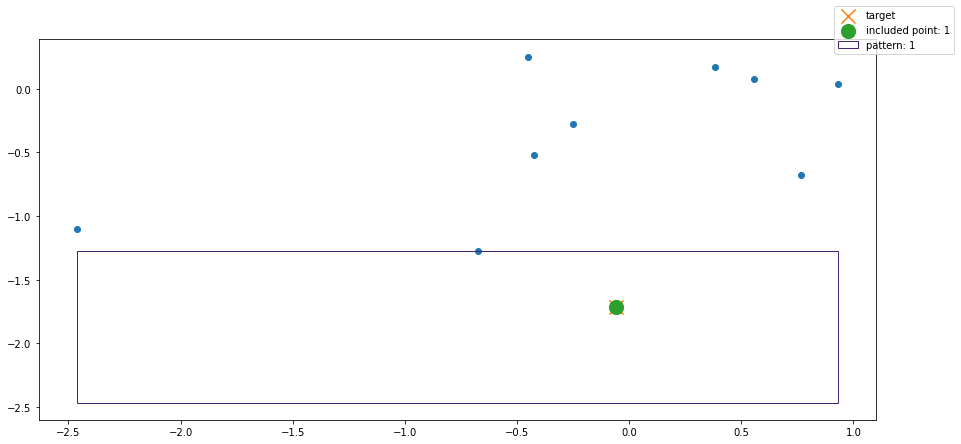

In [8]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,7)

cmap = plt.get_cmap('viridis')

def draw2dpattern(interval, ax, index, total):
    ax.add_patch(patches.Rectangle(
        xy=(interval[0,0], interval[1,0]),
        width=interval[0,1] - interval[0,0],
        height=interval[1,1] - interval[1,0],
        facecolor='none',
        edgecolor=cmap(index/total),
        label=f"pattern: {index}"
        )
    )


plt.scatter(x=training_points[:,0], y=training_points[:,1])
plt.scatter(x=point_to_be_classified[0], y=point_to_be_classified[1], marker="x",  s=200, label="target") 
for i, p in enumerate(included_points):
    plt.scatter(x=p[0], y=p[1], marker="o", s=200, label=f"included point: {np.argwhere(training_points == p)[0,0]}")
ax = plt.gca()
draw2dpattern(intervals, ax, 1, len(training_points))
ax.legend(bbox_to_anchor=(1.1, 1.1))
plt.show()

In [9]:
# min x , min y 
# max x , max y
rare_pattern_detect.largest_bounding_area

array([[-2.46367918, -1.71504644],
       [ 0.92942453,  0.25169164]])

In [10]:
from typing import Callable
import numpy as np
import json

class PACRPAD:
    """
    Superclass for all PAC-RPAD implementations
    """
    def __init__(self, tau, epsilon, delta):
        self.tau = tau
        self.epsilon = epsilon
        self.delta = delta
        self.find_min_f_hat = None

    def has_rare_pattern(self, point) -> bool:
        results = self.find_min_f_hat[f"{point}"]
        if results['objective'] != None:
            results['anomaly'] = results['objective'] <= self.tau + self.epsilon / 2
        return results['anomaly']


class AxisAlignedHyperRectanglePACRPAD(PACRPAD):
    def __init__(self, tau, epsilon, delta):
        super().__init__(tau, epsilon, delta)
        self.solver = None 
        self.training_points = None
        self.testing_points = None

    def construct_f_hat_estimator(self, training_points, testing_points, min_area=0.01):
        def _contains(point: np.ndarray, largest_bounding_area) -> bool:
            return all((largest_bounding_area[0,:] <= point.T) & (point.T <= largest_bounding_area[1,:]))

        self.training_points = training_points
        self.testing_points = testing_points
        dict_results = {}

        # Check if testing points lie within the initial pattern bounds
        dummy_solver = RarePatternDetect(self.training_points, min_area=min_area)
        candidates = []
        for idx, test_p in enumerate(self.testing_points):
            # TODO: extract the largest_bounding_area outside of the solver 
            # TODO: extract the functionalities of evaluating to has rare pattern 
            contained = _contains(test_p, dummy_solver.largest_bounding_area)
            if contained:
                # if yes then add testing_points to ensemble of points used to create the pattern space 
                candidates = [train_p for train_p in self.training_points]
                candidates = np.array(candidates)
                candidates = np.append(candidates, [test_p], axis=0)
                self.solver = RarePatternDetect(candidates, min_area=min_area)
                objective = self.solver.classify(test_p)
                intervals = self.solver.extract_pattern()
                included_points = self.solver.extract_points_included_in_pattern()
                dict_results[f"{test_p}"] =  {
                    'index' : idx,
                    'anomaly' : None,
                    'objective' : objective, 
                    'pattern' : intervals.tolist(), 
                    'included points' : included_points.tolist()
                }
            else:
                # else: anomaly = True
                dict_results[f"{test_p}"] =  {
                    'index' : idx,
                    'anomaly' : True,
                    'objective' : None, 
                    'pattern' : None, 
                    'included points' : None
                }

        with open('minlp_results.json', 'w') as fp:
            json.dump(dict_results, fp, indent=4)

        self.find_min_f_hat = dict_results

In [11]:
exact = AxisAlignedHyperRectanglePACRPAD(tau=0.3, epsilon=0.1, delta=0.1)

In [12]:
testing_points = multivariate_normal.rvs(size=(20,2))
testing_points

array([[-0.63270151,  0.41090764],
       [-1.61348637,  0.54961414],
       [-1.07916572,  0.80160344],
       [-0.90096899,  2.76497148],
       [-0.40907318, -0.79919265],
       [-0.80000493, -0.22488113],
       [-0.98206305,  0.40407691],
       [-2.03067547, -2.00679118],
       [-0.11993144, -1.00420923],
       [-0.63583249, -1.07688354],
       [-1.05371017, -0.12207466],
       [ 0.79311768, -0.44509776],
       [ 1.02712428,  0.98732279],
       [-0.11408486,  0.59531664],
       [ 0.35328339,  0.2211059 ],
       [ 0.01400451,  0.71769124],
       [-0.92479792, -0.59667092],
       [-0.83758085,  0.11671294],
       [-1.97090942,  1.18471669],
       [-0.92899968,  1.58848905]])

In [13]:
exact.construct_f_hat_estimator(training_points, testing_points, min_area=0)
labels_pac_minlp = [exact.has_rare_pattern(x) for x in exact.testing_points]
labels_pac_minlp

---------------------------------------------------------------------------------------------
              Mixed-Integer Nonlinear Decomposition Toolbox in Pyomo (MindtPy)               
---------------------------------------------------------------------------------------------
For more information, please visit https://pyomo.readthedocs.io/en/stable/contributed_packages/mindtpy.html
Original model has 106 constraints (1 nonlinear) and 0 disjunctions, with 61 variables, of which 55 are binary, 0 are integer, and 6 are continuous.
Objective is nonlinear. Moving it to constraint set.
rNLP is the initial strategy being used.

 Iteration | Subproblem Type | Objective Value | Primal Bound |   Dual Bound |   Gap   | Time(s)

         -       Relaxed NLP       3.43842e-09            inf    3.43842e-09      nan%      0.14
         1              MILP          0.147235            inf       0.147235      nan%      0.18
*        1         Fixed NLP          0.757465       0.757465       0.1472

[True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True]

pattern:  None


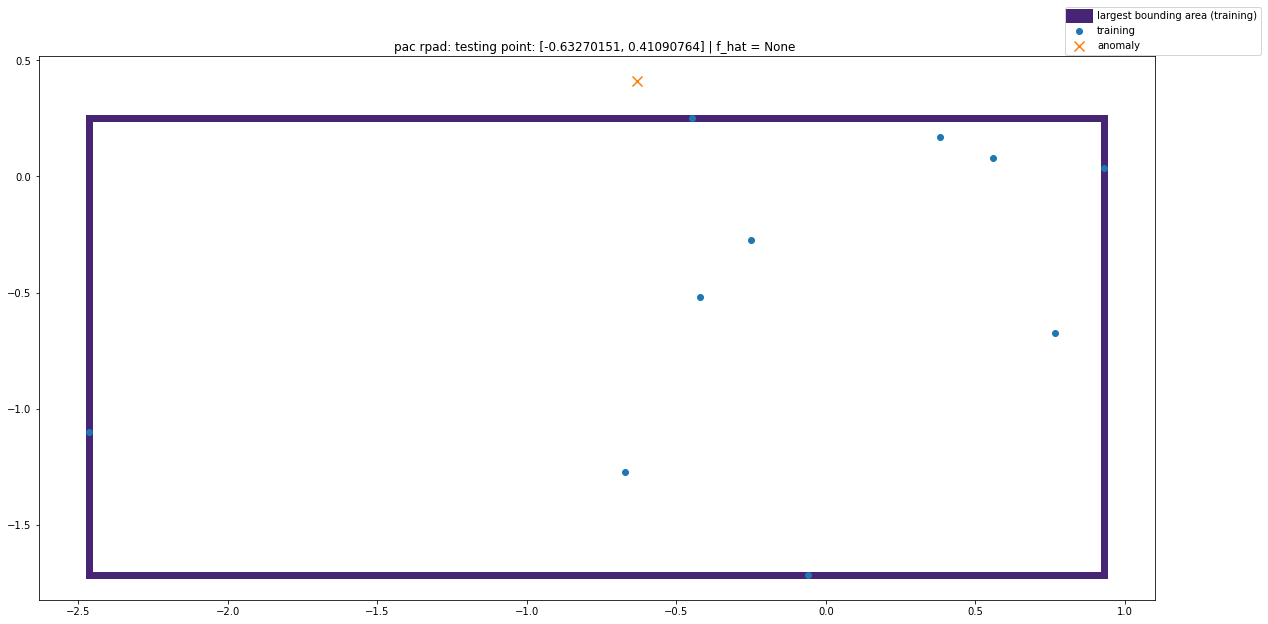

pattern:  None


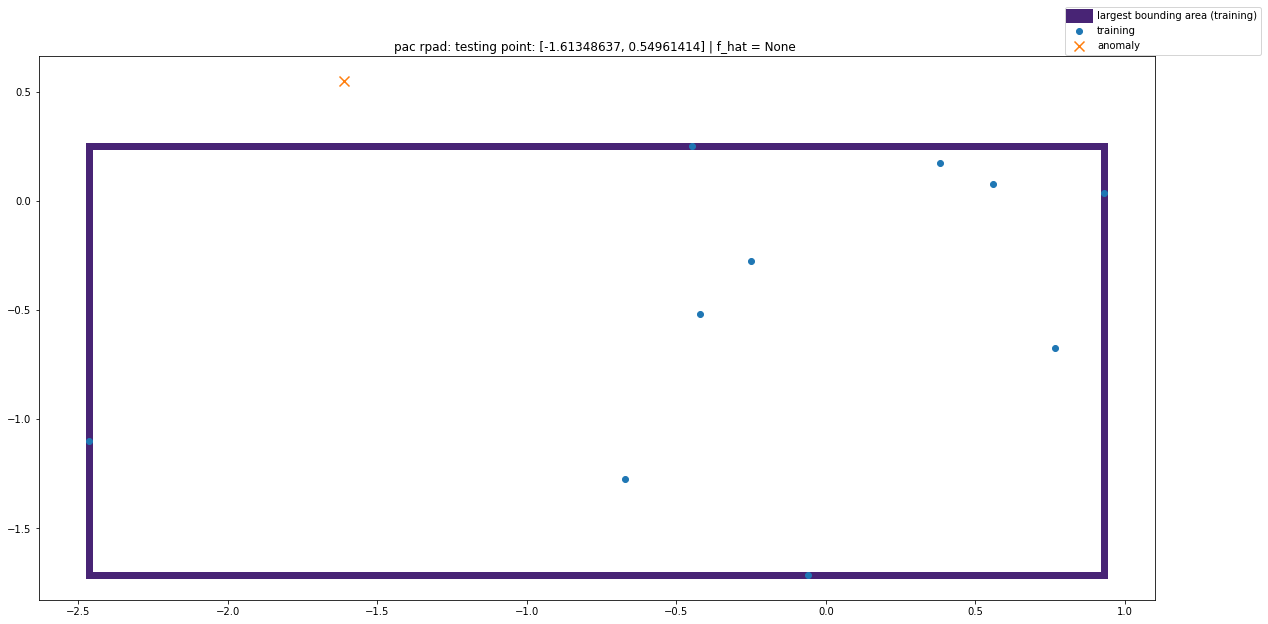

pattern:  None


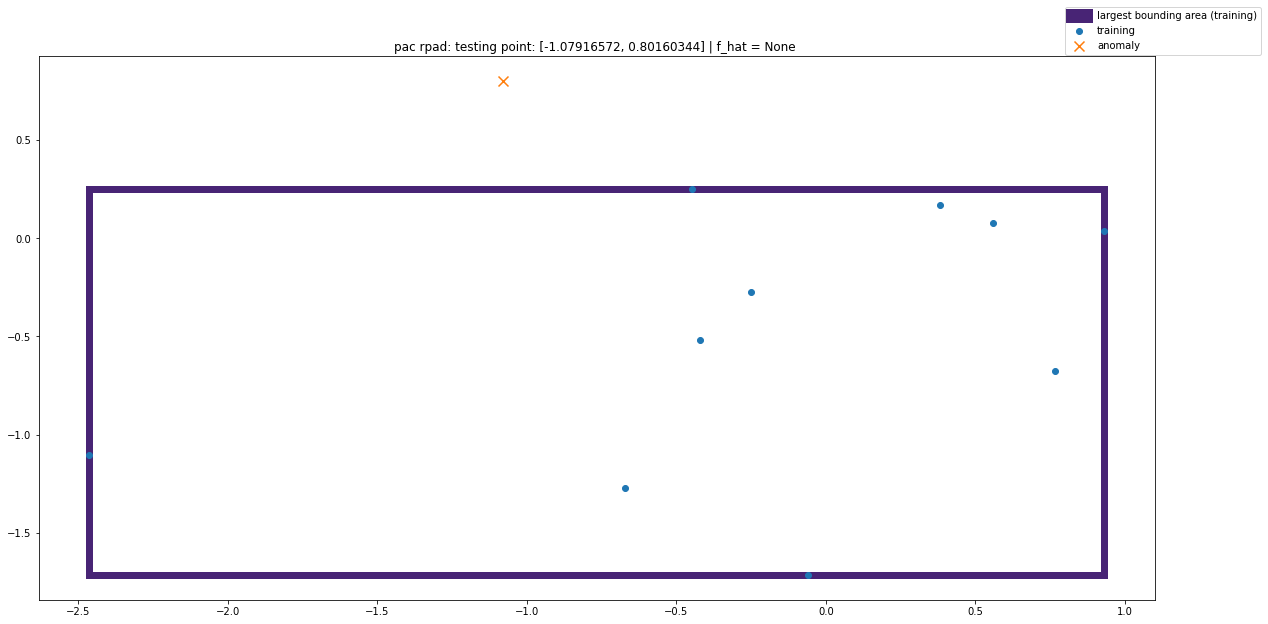

pattern:  None


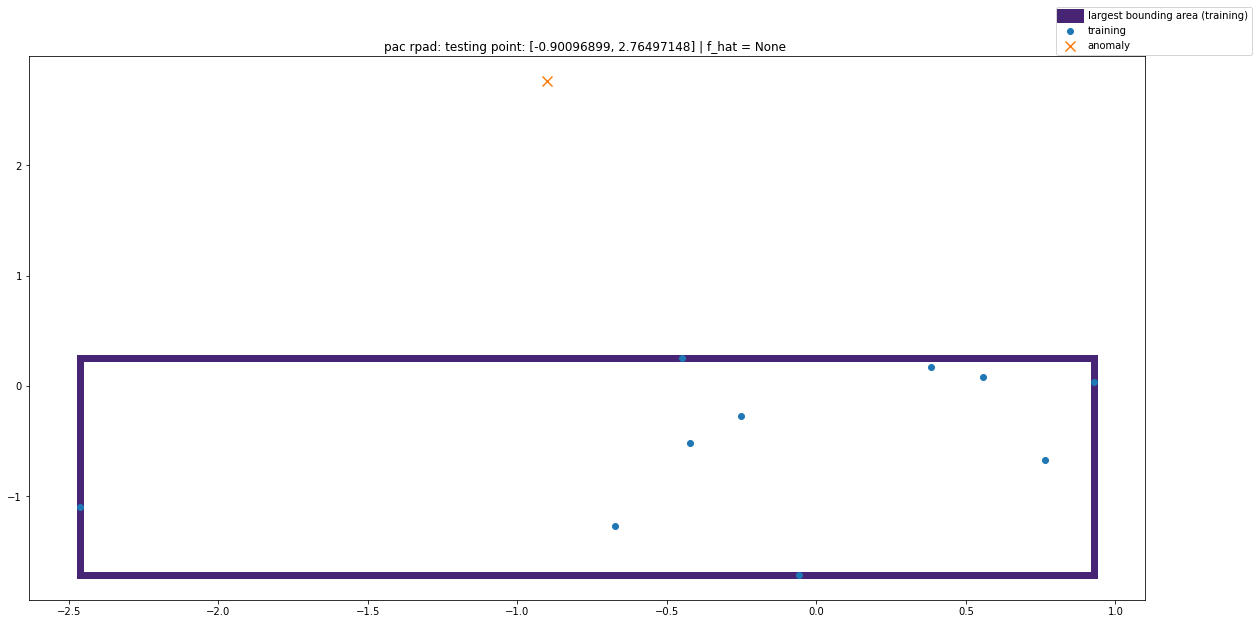

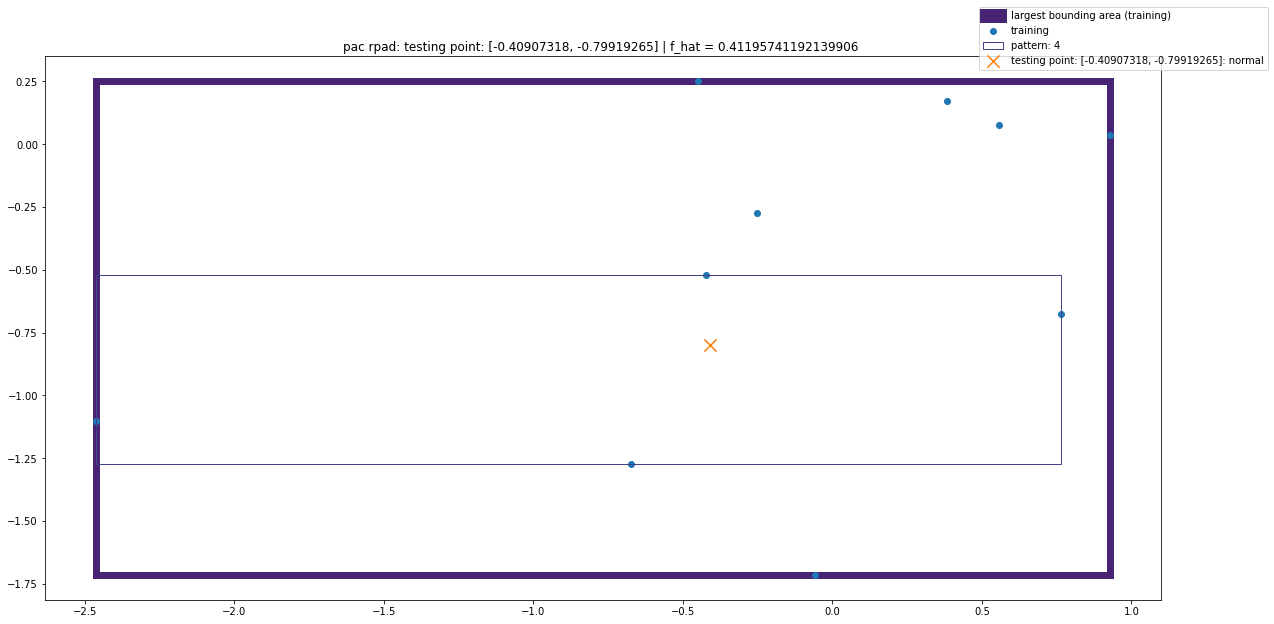

pattern:  [[-2.46267917 -0.67338176]
 [-2.46367916  0.25169164]]


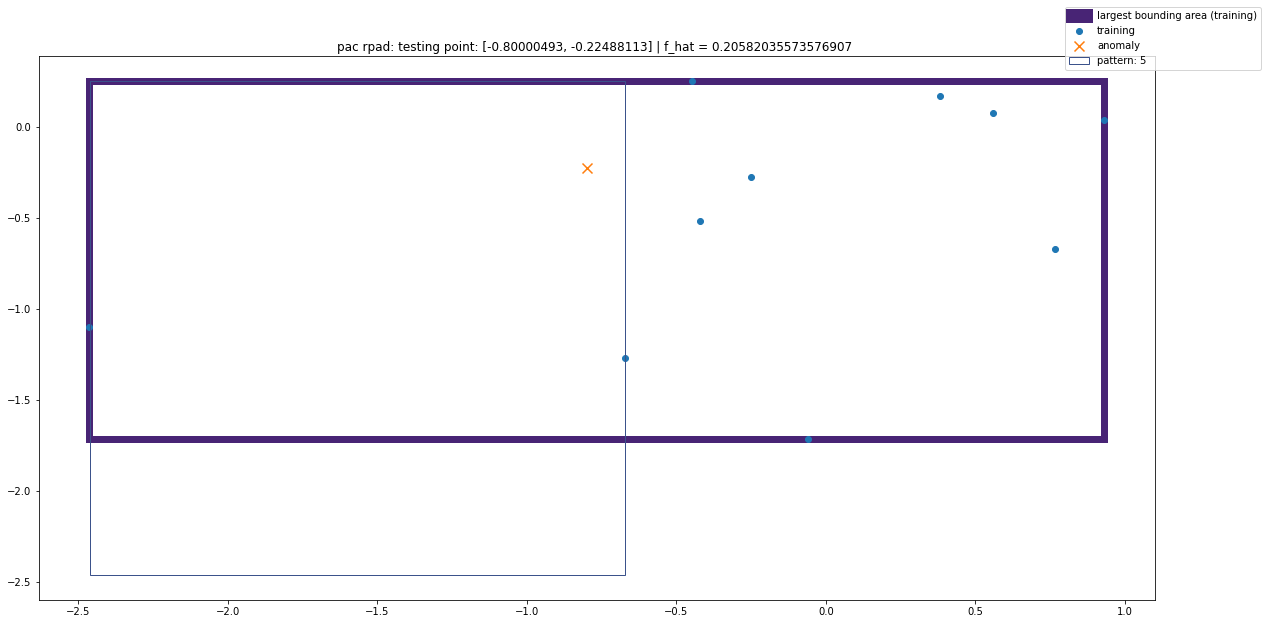

pattern:  None


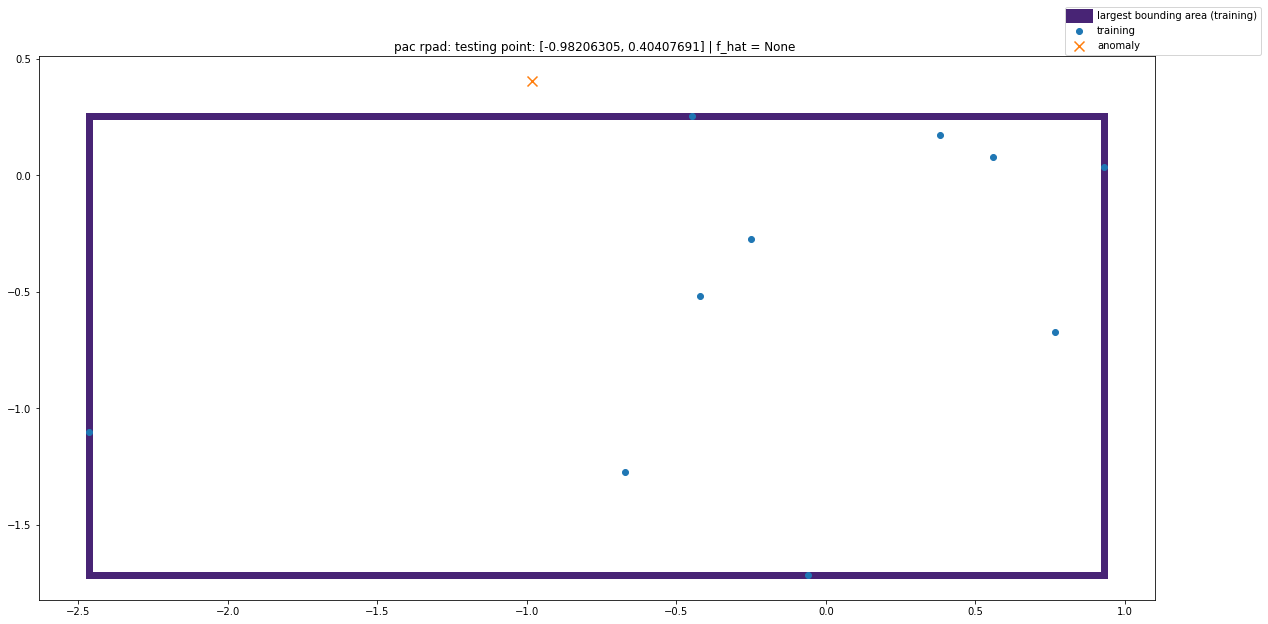

pattern:  None


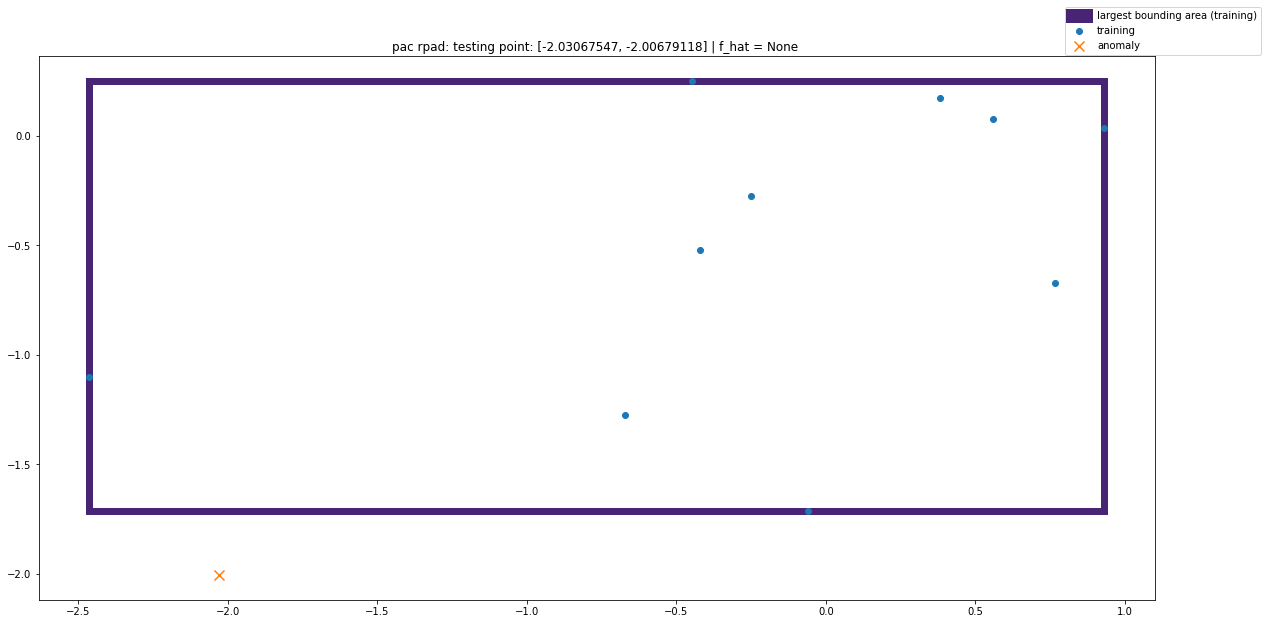

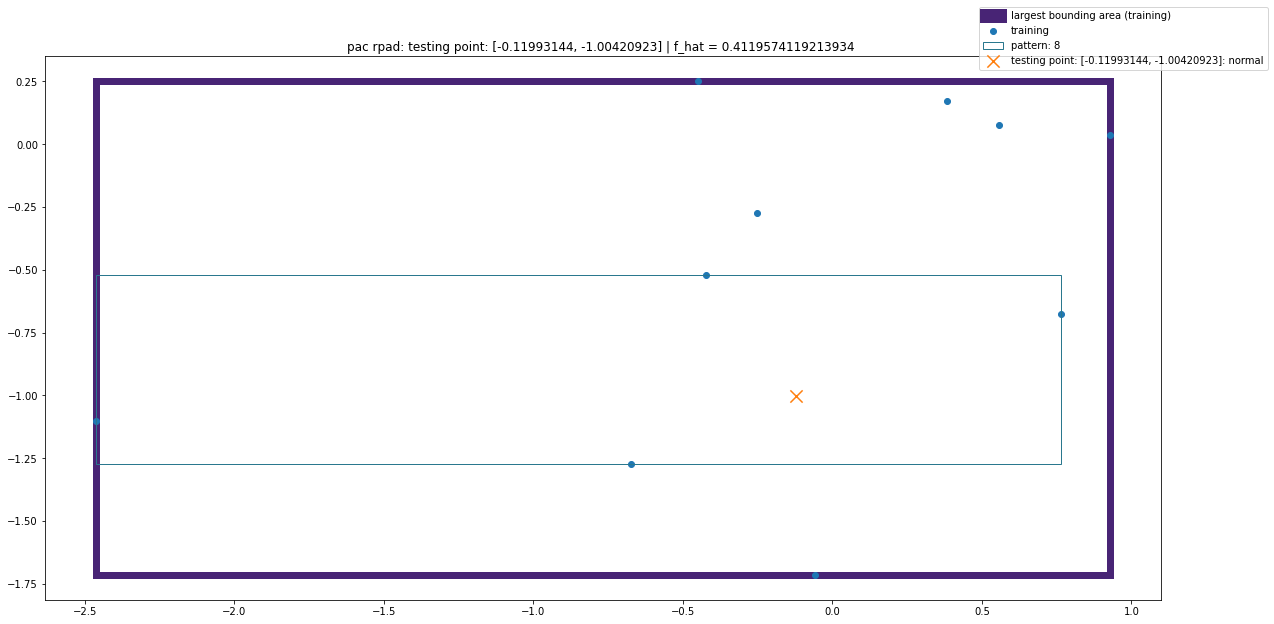

pattern:  [[-2.46267917 -0.4238149 ]
 [-1.27232731  0.25069163]]


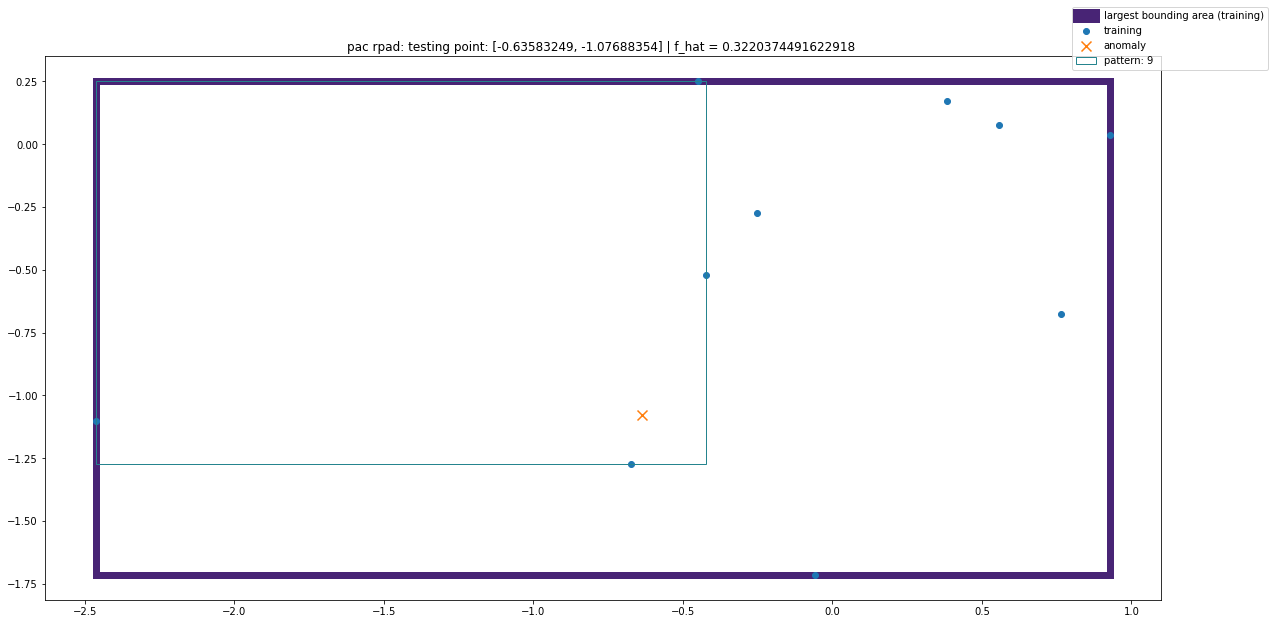

pattern:  [[-2.46267919 -0.67338176]
 [-2.46367915  0.25169164]]


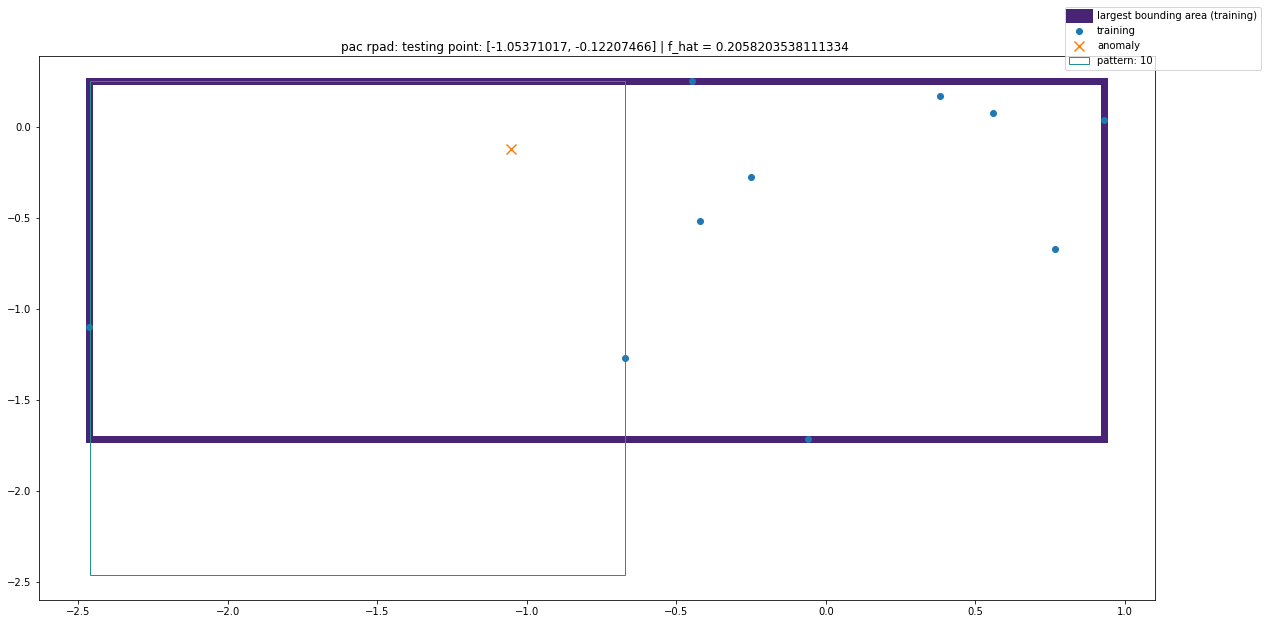

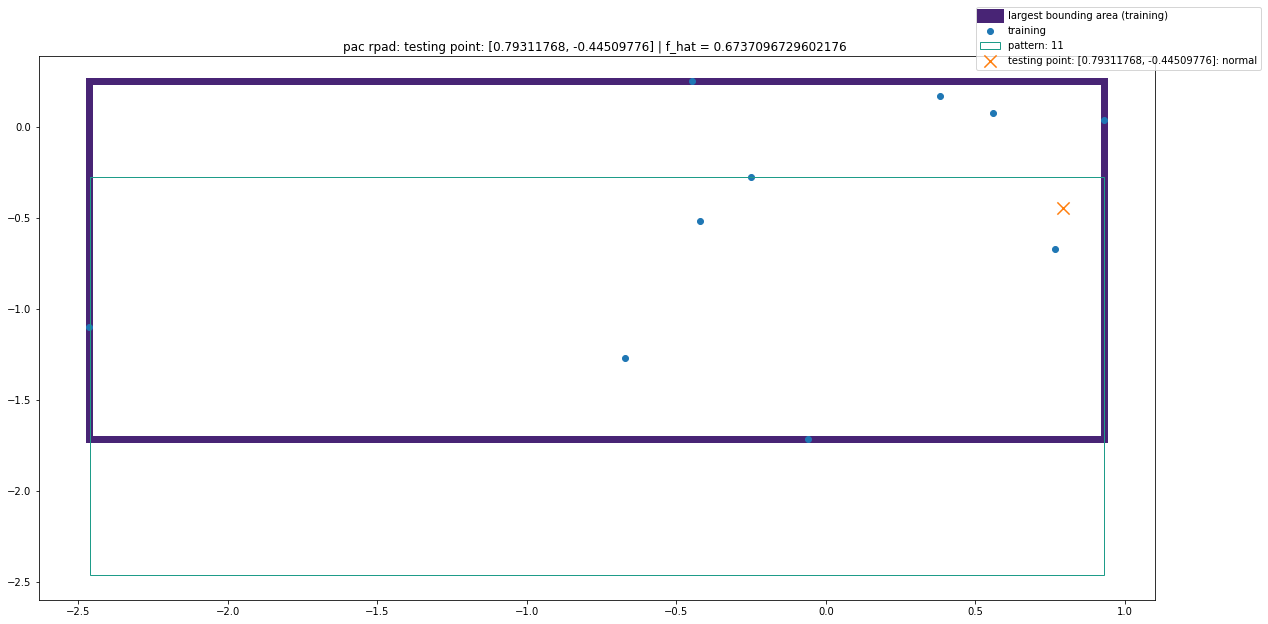

pattern:  None


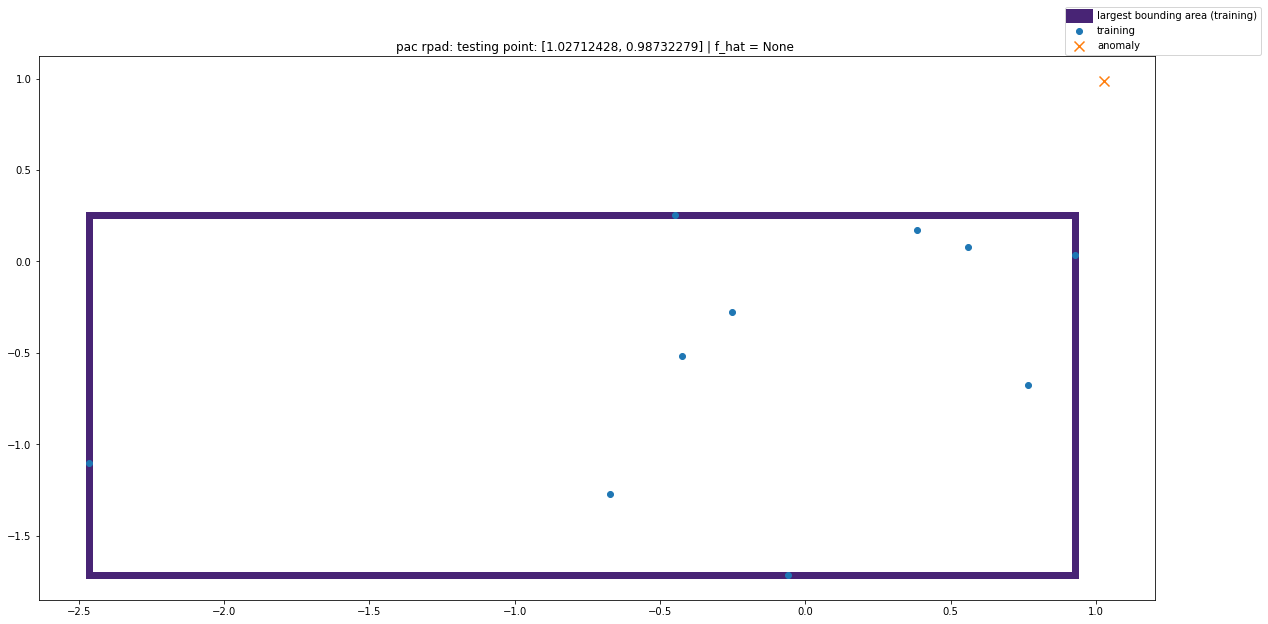

pattern:  None


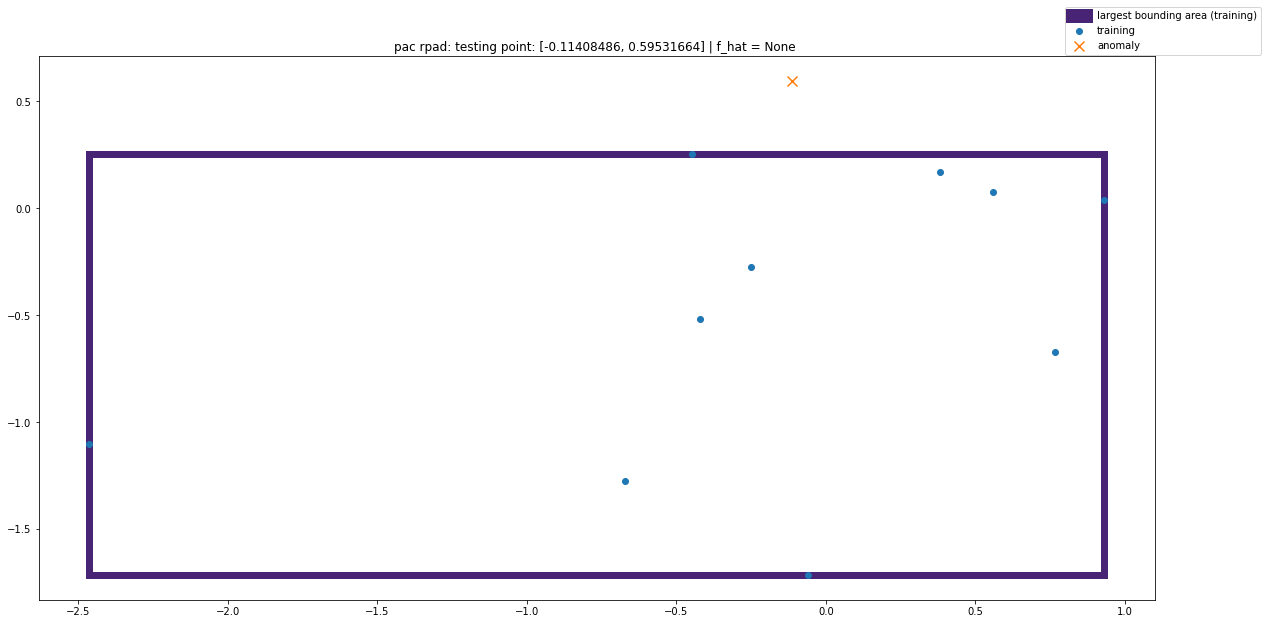

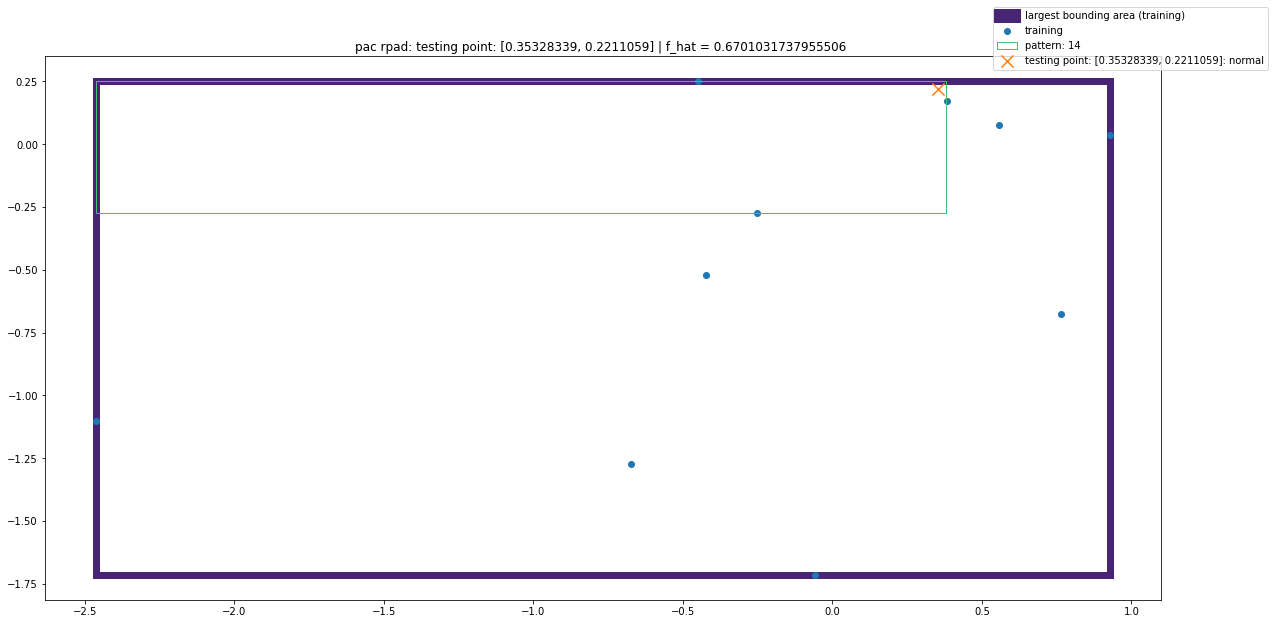

pattern:  None


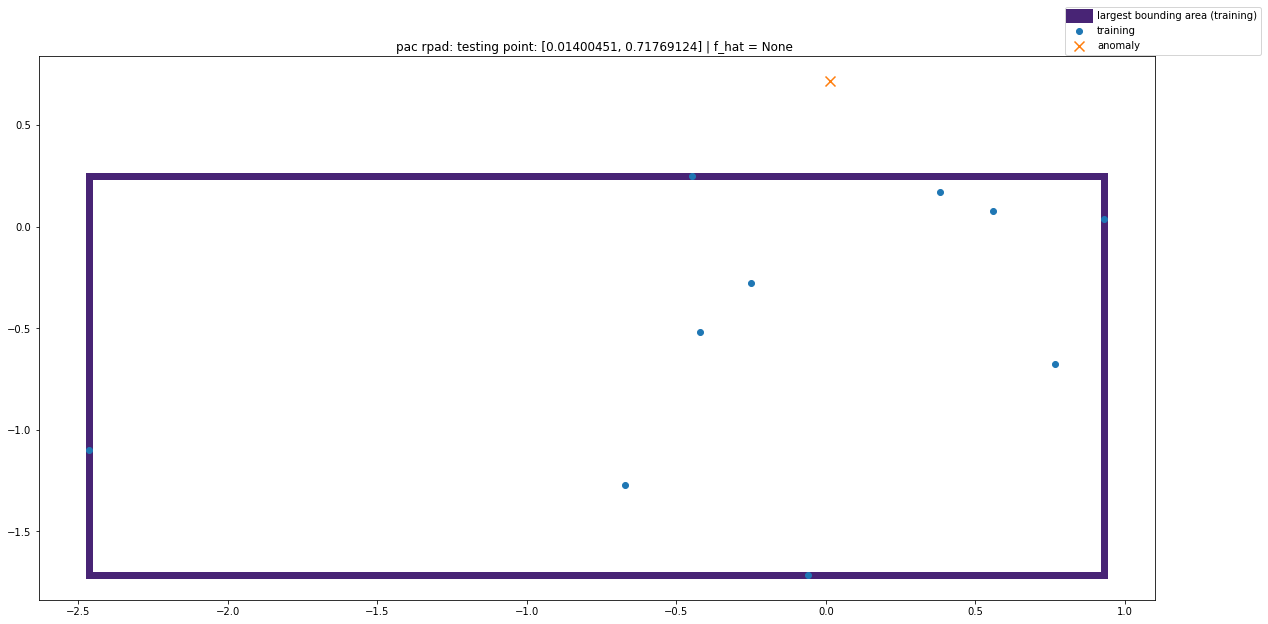

pattern:  [[-2.46267917 -0.67338176]
 [-2.46367916  0.25169164]]


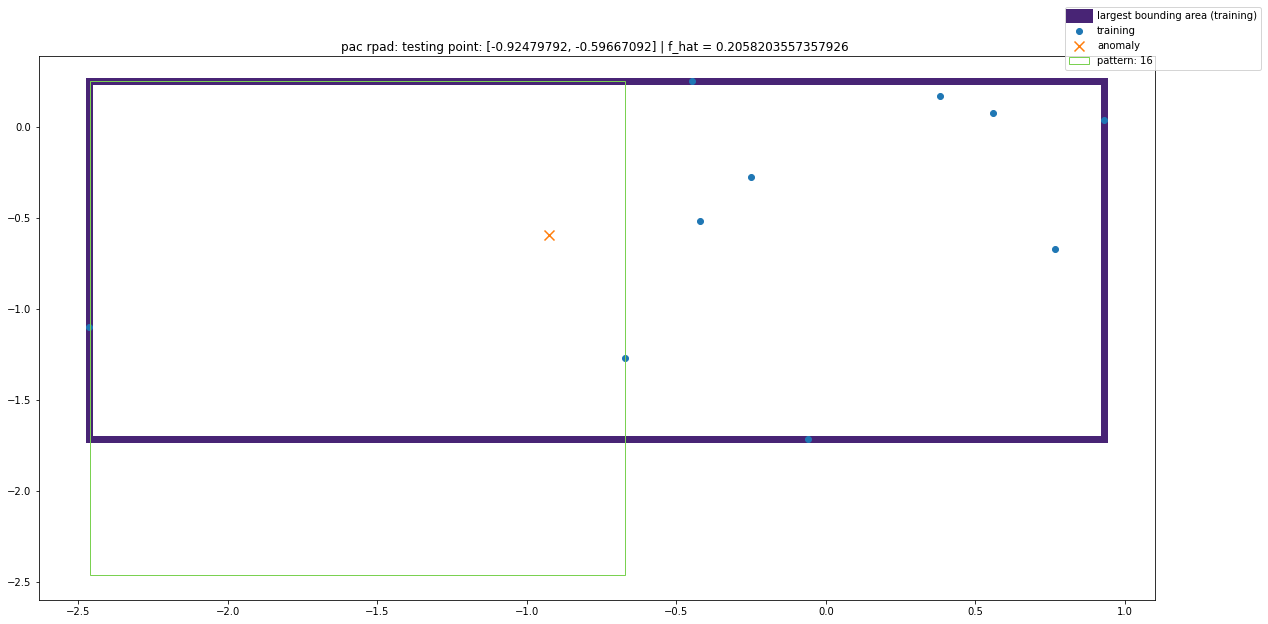

pattern:  [[-2.46267917 -0.67338176]
 [-2.46367916  0.25169164]]


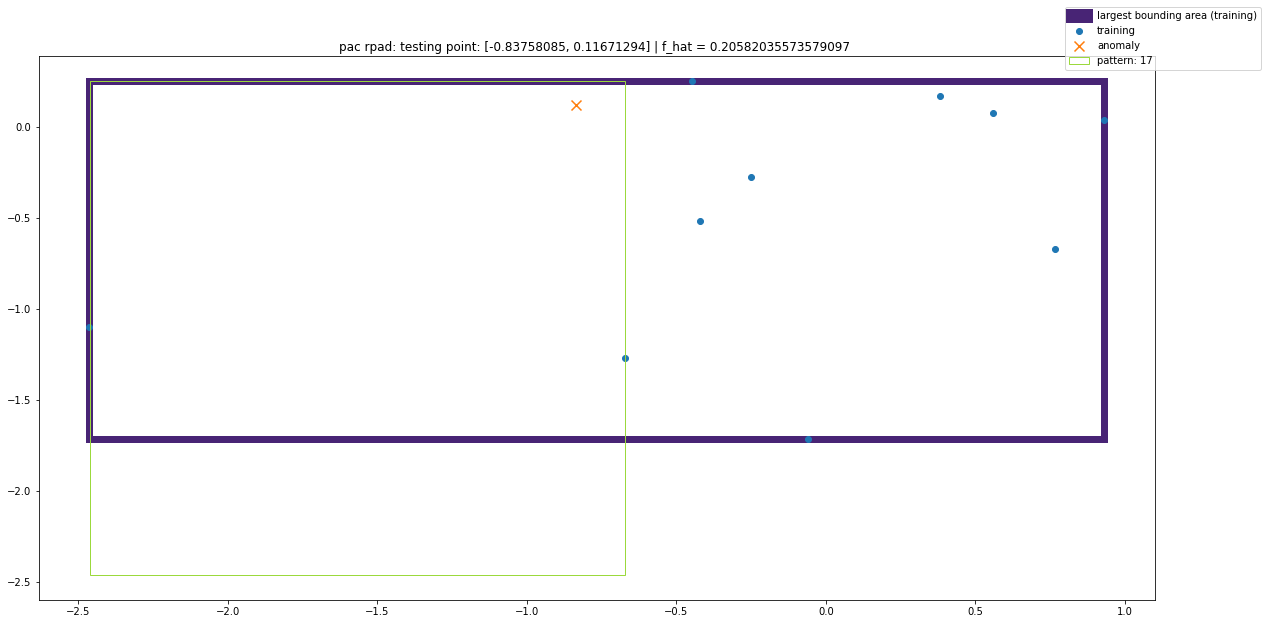

pattern:  None


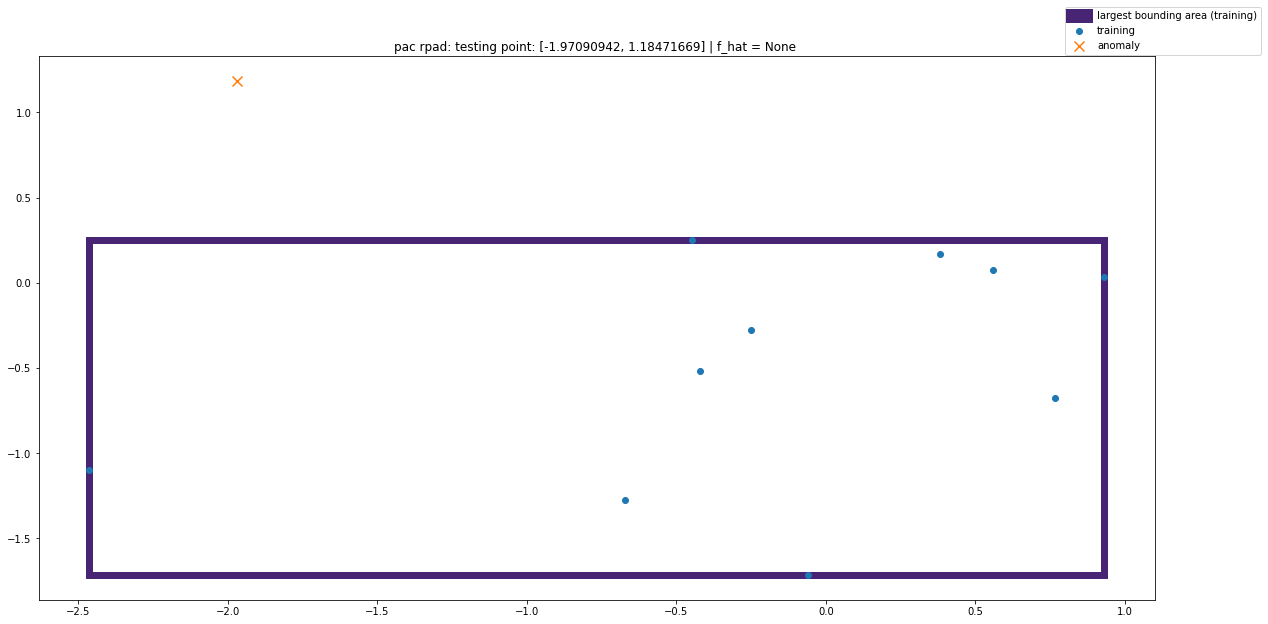

pattern:  None


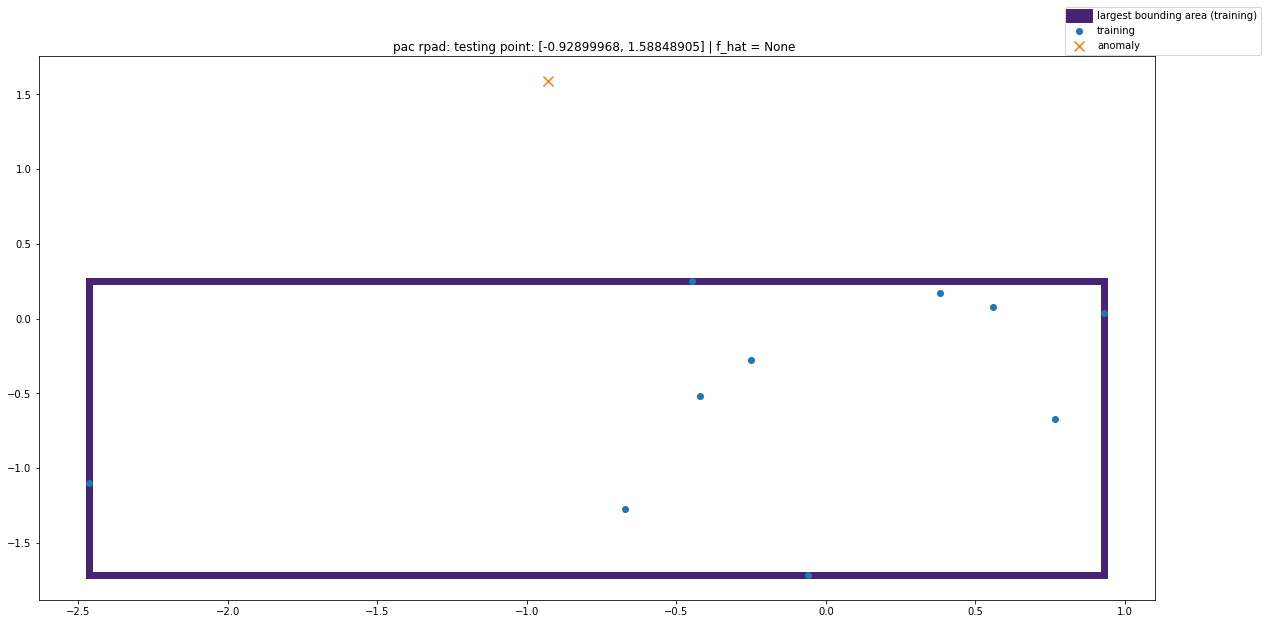

In [14]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

plt.rcParams["figure.figsize"] = (20,10)
cmap = plt.get_cmap('viridis')


def draw_largest_bounding_area(interval, ax):
    ax.add_patch(patches.Rectangle(
        xy=(interval[0,0], interval[1,0]),
        width=interval[0,1] - interval[0,0],
        height=interval[1,1] - interval[1,0],
        facecolor='none',
        edgecolor=cmap(0.1),
        label= "largest bounding area (training)",
        linewidth=7.0
        )
    )


total = len(testing_points)
for i, (k,v) in enumerate(exact.find_min_f_hat.items()):
    ax = plt.gca()
    k = [float(x) for x in k[1:-1].split(" ") if x]
    point = k # exact.testing_points[i]
    draw_largest_bounding_area(exact.solver.largest_bounding_area.T, ax)
    ax.scatter(x=exact.training_points[:,0], y=exact.training_points[:,1], marker="o", label="training")
    pattern = np.array(v['pattern'])
    anomaly = v['anomaly']
    f_hat = v['objective']
    if anomaly:
        plt.scatter(x=k[0], y=k[1], marker="x", s=100, label="anomaly")
        print("pattern: ", pattern)
        if pattern.all() != None:
            draw2dpattern(pattern, ax, i, total)
    else:
        draw2dpattern(pattern, ax, i, total)
        ax.scatter(x=point[0], y=point[1], marker="x", s=150, label=f"testing point: {k}: normal")
    ax.legend(bbox_to_anchor=(1.1, 1.1))
    plt.title(f"pac rpad: testing point: {k} | f_hat = {f_hat} ")
    plt.show()


In [15]:
# TODO: TEST !!!
    # - implemenent simple test (4 points where the correct answer is already known)
    #   - find the correct pattern, respect the boundaries in each of the dim, use simplest training set and simplest test point 
    #   - training set: (0.0,0.0) (2.0,0.0) (0.0,2.0) (2.0,2.0)
    #   - testing point: (1.0,1.0) 
    #   - unit test to test the functionnalities of the functions 
        # run solver and compare with the expected result 
            # - for the pattern intervals 
            # - for the min area 
            # - for the largest_bounding_area
    
# - one important thing is to think about how to configure the min_area value depending on the dataset.
    # min area: fraction of the bounding area, makes it dependent on the number of training points!  